# Experiment 2: Network Topology Variability

**Approach**: Average over shocks first, then analyze variability across networks

## Methodology
1. For each network: Compute mean α* across 500 shock scenarios
2. Across networks: Show mean and 25-75 percentile of these network-level means

## Interpretation
- **Mean line**: Average performance across network topologies
- **Shaded band**: How much does network structure affect results?
- Separates network topology uncertainty from shock randomness


## 1. Setup and Imports

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_array
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Project modules
from risk_analysis import (
    generate_compression_network,
    assign_weights_to_network,
    generate_correlated_shocks,
    compute_buffer_and_shocked_equity
)
from full_payment_algo import full_payment_algo
from CDFD import CDFD_BFF, CDFD_min_cost_pulp
from copula_shock_generator_fixed import generate_gaussian_copula_shocks

# Styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

colors = {
    'original': '#1f77b4',
    'bff': '#ff7f0e',
    'maximal': '#2ca02c',
}
np.set_printoptions(suppress=True, precision=4)

print("✓ Imports complete")

✓ Imports complete


## 2. Experimental Parameters

In [2]:
# Network parameters (FIXED across all shocks)
N = 50
p = 0.5
num_sources = 2
num_sinks = 3
network_seed = 2025
NUM_NETWORKS = 500              # Number of network realizations

# Shock parameters (VARIED)
NUM_SHOCK_SCENARIOS = 100      # Number of independent shock realizations
shock_base_seed = 42           # Base seed for shocks
rho = 0.5                     # Shock correlation

# Gamma sweep parameters
NUM_GAMMA_POINTS = 30         # Number of gamma values to test
GAMMA_MAX_MULTIPLIER =3   # Maximum gamma as multiple of median buffer

# Other parameters
DeltaP = 1.0                   # Payment multiplier

print("Experimental Configuration")
print("=" * 70)
print(f"Network: N={N}, p={p}, seed={network_seed}")
print(f"Shock Scenarios: {NUM_SHOCK_SCENARIOS} independent realizations")
print(f"Shock Correlation: ρ={rho}")
print(f"Gamma Range: [0, {GAMMA_MAX_MULTIPLIER}×median(b)] with {NUM_GAMMA_POINTS} points")
print(f"Total Simulations: {NUM_SHOCK_SCENARIOS} shocks × {NUM_GAMMA_POINTS} gammas × 3 networks")
print(f"                   = {NUM_SHOCK_SCENARIOS * NUM_GAMMA_POINTS * 3:,} evaluations")
print("=" * 70)

Experimental Configuration
Network: N=50, p=0.5, seed=2025
Shock Scenarios: 100 independent realizations
Shock Correlation: ρ=0.5
Gamma Range: [0, 3×median(b)] with 30 points
Total Simulations: 100 shocks × 30 gammas × 3 networks
                   = 9,000 evaluations


## 3. Helper Functions

In [3]:
def compute_shortfall_fixed_buffer(W_net, buffer_vec, gamma, epsilon, DeltaP=1.0, exclude_nodes=None):
    """
    Compute system shortfall using a FIXED buffer vector.
    
    Parameters
    ----------
    W_net : ndarray
        Network adjacency matrix
    buffer_vec : ndarray
        Node-level capital buffers
    gamma : float
        Shock magnitude
    epsilon : ndarray
        Shock realization vector
    DeltaP : float
        Payment multiplier
    exclude_nodes : list or None
        Node indices to exclude from shortfall calculation (e.g., source nodes)
    
    Returns
    -------
    float
        System-level shortfall (excluding specified nodes)
    """
    e0 = buffer_vec - gamma * epsilon
    L = DeltaP * W_net
    p_bar, *_ = full_payment_algo(L, e0)
    
    p_bar_array = np.asarray(p_bar).ravel()
    
    # Exclude source nodes from shortfall calculation
    if exclude_nodes is not None:
        mask = np.ones(len(p_bar_array), dtype=bool)
        mask[exclude_nodes] = False
        return float(p_bar_array[mask].sum())
    else:
        return float(p_bar_array.sum())


def find_tipping_alpha_fixed_gamma(W_net, orig_buffer_base, gamma, epsilon, source_nodes,
                                    alpha_min=0.01, alpha_max=100, tol=1e-3):
    """
    Find critical buffer multiplier α* where shortfall transitions from 0 to > 0.
    
    MODIFIED: Shortfalls at source nodes are IGNORED (excluded from calculation).
    We only care about shortfalls at non-source nodes (core + sink nodes).
    
    Parameters
    ----------
    W_net : ndarray
        Network adjacency matrix
    orig_buffer_base : ndarray
        Original buffer structure (before scaling)
    gamma : float
        Shock magnitude
    epsilon : ndarray
        Shock realization vector
    source_nodes : list
        Indices of source nodes (shortfalls at these nodes are ignored)
    alpha_min, alpha_max : float
        Search bounds for alpha
    tol : float
        Tolerance for binary search
        
    Returns
    -------
    float
        Critical buffer multiplier alpha*
    """
    def shortfall_at_alpha(alpha):
        # Scale all buffers by alpha (including source nodes)
        buffer_vec = alpha * orig_buffer_base
        
        # Compute shortfall, but exclude source nodes
        return compute_shortfall_fixed_buffer(W_net, buffer_vec, gamma, epsilon, 
                                              DeltaP=1.0, exclude_nodes=source_nodes)
    
    # Check bounds
    sf_min = shortfall_at_alpha(alpha_min)
    sf_max = shortfall_at_alpha(alpha_max)
    
    if sf_min < 1e-6:
        return alpha_min
    
    # Expand upper bound if needed
    while sf_max > 1e-6 and alpha_max < 1e6:
        alpha_max *= 2.0
        sf_max = shortfall_at_alpha(alpha_max)
    
    # Binary search
    left, right = alpha_min, alpha_max
    iterations = 0
    
    while right - left > tol and iterations < 100:
        mid = 0.5 * (left + right)
        sf_mid = shortfall_at_alpha(mid)
        if sf_mid > 1e-6:
            left = mid
        else:
            right = mid
        iterations += 1
    
    return 0.5 * (left + right)


print("✓ Helper functions defined")
print(f"  - compute_shortfall_fixed_buffer() [can exclude nodes from calculation]")
print(f"  - find_tipping_alpha_fixed_gamma() [MODIFIED: ignores source node shortfalls]")

✓ Helper functions defined
  - compute_shortfall_fixed_buffer() [can exclude nodes from calculation]
  - find_tipping_alpha_fixed_gamma() [MODIFIED: ignores source node shortfalls]


## 4. Network Setup and Compression

Generate and compress a single network that will be tested across all shock scenarios.

In [4]:
# Generate multiple networks
print("Generating multiple networks...")
networks_list = {}
source_nodes_list = []  # Store source nodes for each network

for net_idx in range(NUM_NETWORKS):
    seed = network_seed + net_idx
    
    # Generate network
    W_struct, source_nodes, core_nodes, sink_nodes = generate_compression_network(
        N, p, num_sources, num_sinks, seed=seed
    )
    W = assign_weights_to_network(W_struct, alpha=2.0, scale=1.0)
    W_sparse = csr_array(W)
    
    # Store source nodes
    source_nodes_list.append(source_nodes)
    
    # Store original
    if net_idx == 0:
        networks_list['Original'] = []
    networks_list['Original'].append(W)
    
    # Compress with BFF
    try:
        _, D = CDFD_BFF(W_sparse, TOL_ZERO=1e-5)
        if net_idx == 0:
            networks_list['BFF'] = []
        networks_list['BFF'].append(D.toarray())
    except Exception as e:
        print(f"  Network {net_idx} BFF failed: {e}")
    
    # Compress with Maximal
    try:
        _, D = CDFD_min_cost_pulp(W_sparse, TOL_ZERO=1e-5)
        if net_idx == 0:
            networks_list['Maximal'] = []
        networks_list['Maximal'].append(D.toarray())
    except Exception as e:
        print(f"  Network {net_idx} Maximal failed: {e}")

# Determine active methods
active_methods = list(networks_list.keys())
print(f"\n✓ Generated {NUM_NETWORKS} networks")
print(f"  Active methods: {active_methods}")
print(f"  Networks per method: {len(networks_list['Original'])}")
print(f"  Source nodes (network 0): {source_nodes_list[0]}")

# Compute median buffer from first original network
median_buffer = np.median(networks_list['Original'][0].sum(axis=1))
print(f"\nMedian buffer (network 0): {median_buffer:.2f}")


Generating multiple networks...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yijie/.pyenv/versions/3.11.12/envs/myenv311/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/8m/tlrl9p6s7371ym2ydbzyxkbw0000gn/T/6721efb68a3b451cb692c456f9967136-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/8m/tlrl9p6s7371ym2ydbzyxkbw0000gn/T/6721efb68a3b451cb692c456f9967136-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 60 COLUMNS
At line 4105 RHS
At line 4161 BOUNDS
At line 5510 ENDATA
Problem MODEL has 55 rows, 1348 columns and 2696 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 54 (-1) rows, 1323 (-25) columns and 2646 (-50) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 5.5448568e-05 ( 0.0055448568%) - largest zero change 0
0  Obj 218.3066 Primal inf 823.67325 (54)
46  Obj 605.6964 Primal 

## 5. Multi-Shock Gamma Sensitivity Analysis

Run gamma sweep across multiple shock scenarios and aggregate results.

In [5]:
# Determine gamma range
gamma_max = GAMMA_MAX_MULTIPLIER * median_buffer
gamma_values = np.linspace(0.0, gamma_max, NUM_GAMMA_POINTS)

print("Running multi-network, multi-shock gamma sensitivity analysis...")
print("=" * 70)
print(f"Gamma range: [0, {gamma_max:.2f}] ({NUM_GAMMA_POINTS} points)")
print(f"Networks: {NUM_NETWORKS}")
print(f"Shock scenarios per network: {NUM_SHOCK_SCENARIOS}")
print(f"Total simulations: {NUM_NETWORKS * NUM_SHOCK_SCENARIOS * NUM_GAMMA_POINTS * len(active_methods):,}")
print()
print("NOTE: Source node shortfalls are IGNORED in tipping point calculation")
print("      Only shortfalls at non-source nodes (core + sink) are counted")
print()

# Storage: {method: (NUM_NETWORKS, NUM_GAMMA, NUM_SHOCKS)}
all_tipping_alphas = {
    method: np.zeros((NUM_NETWORKS, NUM_GAMMA_POINTS, NUM_SHOCK_SCENARIOS))
    for method in active_methods
}

# Run analysis across all networks
for net_idx in range(NUM_NETWORKS):
    if (net_idx + 1) % 5 == 0:
        print(f"  Processing network {net_idx + 1}/{NUM_NETWORKS}...")
    
    source_nodes = source_nodes_list[net_idx]
    
    for shock_idx in range(NUM_SHOCK_SCENARIOS):
        # Generate shock (unique per network-shock combination)
        shock_seed = shock_base_seed + net_idx * 10000 + shock_idx
        epsilon = generate_gaussian_copula_shocks(N + num_sources + num_sinks, rho, n_samples=1, seed=shock_seed).ravel()
        
        # For each gamma value
        for gamma_idx, gamma in enumerate(gamma_values):
            # For each network method
            for method_name in active_methods:
                W_net = networks_list[method_name][net_idx]
                orig_buffer = networks_list['Original'][net_idx].sum(axis=1)
                
                # Find tipping point alpha (ignoring source node shortfalls)
                alpha_star = find_tipping_alpha_fixed_gamma(
                    W_net, orig_buffer, gamma, epsilon, source_nodes
                )
                all_tipping_alphas[method_name][net_idx, gamma_idx, shock_idx] = alpha_star

print()
print("=" * 70)
print("✓ Tipping point analysis complete")
print("  Source node shortfalls were excluded from all calculations")

Running multi-network, multi-shock gamma sensitivity analysis...
Gamma range: [0, 143.79] (30 points)
Networks: 500
Shock scenarios per network: 100
Total simulations: 4,500,000

NOTE: Source node shortfalls are IGNORED in tipping point calculation
      Only shortfalls at non-source nodes (core + sink) are counted

  Processing network 5/500...
  Processing network 10/500...
  Processing network 15/500...
  Processing network 20/500...
  Processing network 25/500...
  Processing network 30/500...
  Processing network 35/500...
  Processing network 40/500...
  Processing network 45/500...
  Processing network 50/500...
  Processing network 55/500...
  Processing network 60/500...
  Processing network 65/500...
  Processing network 70/500...
  Processing network 75/500...
  Processing network 80/500...
  Processing network 85/500...
  Processing network 90/500...
  Processing network 95/500...
  Processing network 100/500...
  Processing network 105/500...
  Processing network 110/500..

In [6]:
# all_tipping_alphas

## 6. Aggregate Results Across Shocks

Compute mean and standard deviation of metrics across all shock scenarios.

In [7]:
print("Computing aggregated metrics (Option 1: Network variability)...")
print("=" * 70)
print("Step 1: Average over shocks for each network")
print("Step 2: Compute statistics across networks")
print()

# Storage for results
results = {
    'gamma_values': gamma_values,
    'networks': {}
}

# For each compression method
for method_name in active_methods:
    method_alphas = all_tipping_alphas[method_name]  # (NUM_NETWORKS, NUM_GAMMA, NUM_SHOCKS)
    original_alphas = all_tipping_alphas['Original']  # (NUM_NETWORKS, NUM_GAMMA, NUM_SHOCKS)
    
    # Compute network flow statistics
    network_sums = np.array([net.sum() for net in networks_list[method_name]])
    original_sums = np.array([net.sum() for net in networks_list['Original']])
    flow_retained_mean = (network_sums / original_sums).mean()
    
    # STEP 1: Average over shocks (axis=2)
    # Result: (NUM_NETWORKS, NUM_GAMMA) - one value per network per gamma
    method_alphas_mean = method_alphas.mean(axis=2)  # Average over 500 shocks
    original_alphas_mean = original_alphas.mean(axis=2)
    
    if method_name != 'Original':
        # CR per network (after averaging over shocks)
        # Shape: (NUM_NETWORKS, NUM_GAMMA)
        cr_per_network = method_alphas_mean / original_alphas_mean
        
        # ERLS per network (using original sum consistently)
        # Shape: (NUM_NETWORKS, NUM_GAMMA)
        original_sums_expanded = original_sums[:, np.newaxis]  # (NUM_NETWORKS, 1)
        numerator = original_alphas_mean * original_sums_expanded - method_alphas_mean * original_sums_expanded
        denominator = original_alphas_mean * original_sums_expanded
        erls_per_network = numerator / denominator  # = 1 - CR
        
        # STEP 2: Compute statistics across networks (axis=0)
        # For each gamma: statistics over 30 networks
        cr_mean = cr_per_network.mean(axis=0)      # Mean across networks
        cr_std = cr_per_network.std(axis=0)        # Std across networks
        cr_p25 = np.percentile(cr_per_network, 25, axis=0)
        cr_p75 = np.percentile(cr_per_network, 75, axis=0)
        
        erls_mean = erls_per_network.mean(axis=0)
        erls_std = erls_per_network.std(axis=0)
        erls_p25 = np.percentile(erls_per_network, 25, axis=0)
        erls_p75 = np.percentile(erls_per_network, 75, axis=0)
        
        alpha_mean = method_alphas_mean.mean(axis=0)
        alpha_std = method_alphas_mean.std(axis=0)
        
        # Store per-network data for detailed analysis
        cr_all_networks = cr_per_network
        erls_all_networks = erls_per_network
    else:
        cr_mean = np.ones(NUM_GAMMA_POINTS)
        cr_std = np.zeros(NUM_GAMMA_POINTS)
        cr_p25 = np.ones(NUM_GAMMA_POINTS)
        cr_p75 = np.ones(NUM_GAMMA_POINTS)
        
        erls_mean = np.zeros(NUM_GAMMA_POINTS)
        erls_std = np.zeros(NUM_GAMMA_POINTS)
        erls_p25 = np.zeros(NUM_GAMMA_POINTS)
        erls_p75 = np.zeros(NUM_GAMMA_POINTS)
        
        alpha_mean = original_alphas_mean.mean(axis=0)
        alpha_std = original_alphas_mean.std(axis=0)
        
        cr_all_networks = None
        erls_all_networks = None
    
    # Store results
    results['networks'][method_name] = {
        'alpha_mean': alpha_mean,
        'alpha_std': alpha_std,
        'cr_mean': cr_mean,
        'cr_std': cr_std,
        'cr_p25': cr_p25,
        'cr_p75': cr_p75,
        'erls_mean': erls_mean,
        'erls_std': erls_std,
        'erls_p25': erls_p25,
        'erls_p75': erls_p75,
        'cr_all_networks': cr_all_networks,      # (NUM_NETWORKS, NUM_GAMMA)
        'erls_all_networks': erls_all_networks,  # (NUM_NETWORKS, NUM_GAMMA)
        'flow_retained': flow_retained_mean
    }
    
    if method_name != 'Original':
        print(f"{method_name}:")
        print(f"  Flow retained: {flow_retained_mean:.1%}")
        print(f"  ERLS range (mean across networks): [{erls_mean.min():.3f}, {erls_mean.max():.3f}]")
        print(f"  ERLS network variability (IQR): {(erls_p75 - erls_p25).mean():.3f}")
        print(f"  CR range (mean across networks): [{cr_mean.min():.3f}, {cr_mean.max():.3f}]")
        print(f"  CR network variability (IQR): {(cr_p75 - cr_p25).mean():.3f}")
        print()

print("=" * 70)
print("✓ Aggregation complete")
print(f"  Each point: Mean over 500 shocks")
print(f"  Shaded band: 25-75 percentile across 30 networks")


Computing aggregated metrics (Option 1: Network variability)...
Step 1: Average over shocks for each network
Step 2: Compute statistics across networks

BFF:
  Flow retained: 25.7%
  ERLS range (mean across networks): [0.002, 0.461]
  ERLS network variability (IQR): 0.021
  CR range (mean across networks): [0.539, 0.998]
  CR network variability (IQR): 0.021

Maximal:
  Flow retained: 21.3%
  ERLS range (mean across networks): [0.011, 0.461]
  ERLS network variability (IQR): 0.028
  CR range (mean across networks): [0.539, 0.989]
  CR network variability (IQR): 0.028

✓ Aggregation complete
  Each point: Mean over 500 shocks
  Shaded band: 25-75 percentile across 30 networks


## 7. Visualization 1: ERLS vs Gamma

Plot mean ERLS with shaded standard deviation bands.

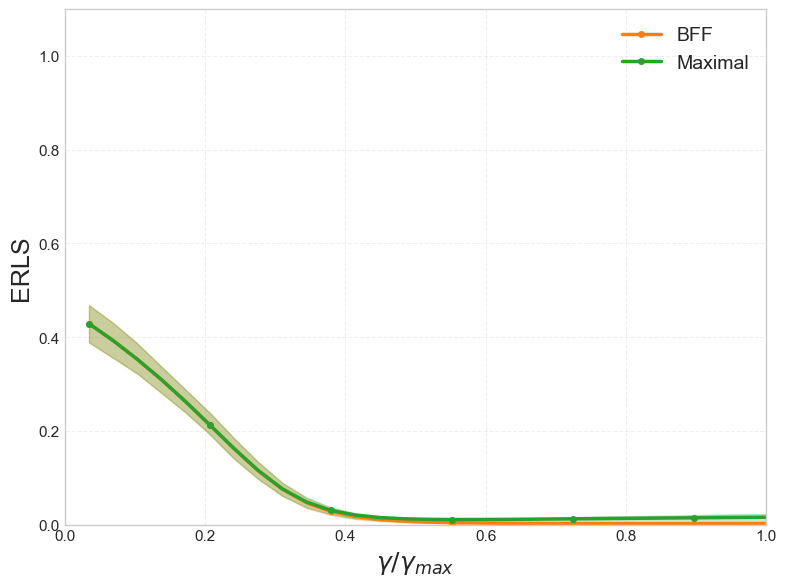

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Normalize gamma
gamma_normalized = gamma_values / gamma_values.max()
mask = gamma_normalized > 0  # Exclude gamma=0

for method_name in active_methods:
    if method_name == 'Original':
        continue
    
    erls_mean = results['networks'][method_name]['erls_mean'][mask]
    erls_p25 = results['networks'][method_name]['erls_p25'][mask]
    erls_p75 = results['networks'][method_name]['erls_p75'][mask]
    flow_retained = results['networks'][method_name]['flow_retained']
    
    # Plot mean line (mean across networks, after averaging over shocks)
    label = f'{method_name}'
    line = ax.plot(gamma_normalized[mask], erls_mean, linewidth=2.5, 
                   label=label, marker='o', markersize=4, markevery=5,color=colors[method_name.lower()])[0]
    
    # Fill 25-75 percentile band (variability across networks)
    ax.fill_between(gamma_normalized[mask], erls_p25, erls_p75, 
                    alpha=0.25,color=colors[method_name.lower()])

ax.set_xlabel(r'$\gamma / \gamma_{max}$', fontsize=18)
ax.set_ylabel(r'ERLS', fontsize=18)
# ax.set_title(f'Buffer Multiplier Savings vs Shock Magnitude\n' +
#              f'Mean across {NUM_NETWORKS} networks (each averaged over {NUM_SHOCK_SCENARIOS} shocks)\n' +
#              f'Shaded: Network topology variability (25-75 percentile)',
#              fontsize=13, fontweight='bold')
ax.legend(fontsize=14, loc='best')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)
# ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('figures/Experiment2_figure1_ERLS_vs_gamma.png', dpi=300, bbox_inches='tight')
plt.show()


## 8. Visualization 2: $\kappa_{fw}$ vs Gamma

Plot mean Conservativeness Ratio with shaded standard deviation bands.

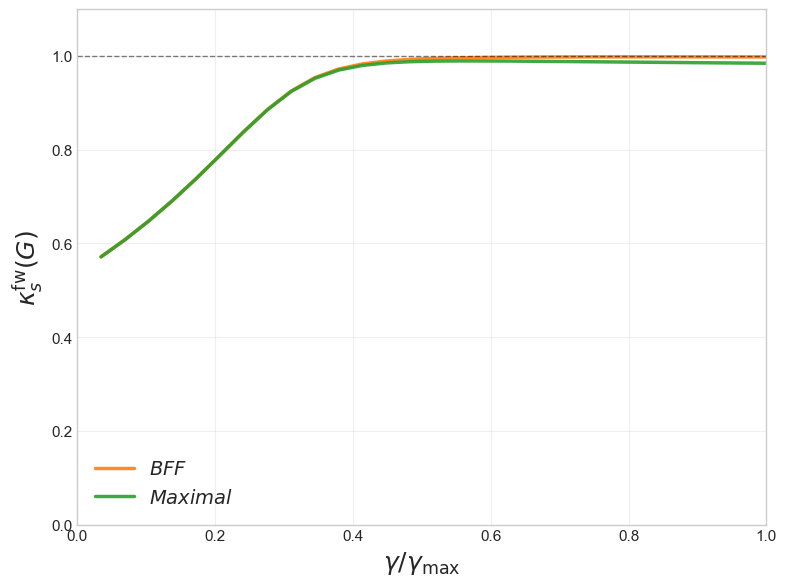

✓ Figure saved: experiment2_figure2_cr_vs_gamma.png
  Shaded regions represent ± 1 standard deviation across 100 shock scenarios


In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for method_name in active_methods:
    if method_name == 'Original':
        continue
    
    cr_mean = results['networks'][method_name]['cr_mean'][mask]
    cr_std = results['networks'][method_name]['cr_std'][mask]
    
    # Plot mean line
    ax.plot(gamma_normalized[mask], cr_mean, '-', linewidth=2.5,
            label=rf'${method_name}$',
            color=colors[method_name.lower()], alpha=0.9)
    
    # # Shaded std region
    # ax.fill_between(gamma_values, cr_mean - cr_std, cr_mean + cr_std,
    #                  color=colors[method_name.lower()], alpha=0.2)

# Reference line
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel(r'$\gamma / \gamma_{\mathrm{max}}$', fontsize=18)
ax.set_ylabel(r'$\kappa^{\mathrm{fw}}_s(G)$', fontsize=18)
ax.legend(fontsize=14, framealpha=0.9, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.1)
plt.tight_layout()
# plt.savefig('figures/experiment2_figure2_kappa_vs_gamma.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved: experiment2_figure2_cr_vs_gamma.png")
print(f"  Shaded regions represent ± 1 standard deviation across {NUM_SHOCK_SCENARIOS} shock scenarios")

## Visualization 2: Conservativeness Ratio (κ_fw) vs Gamma


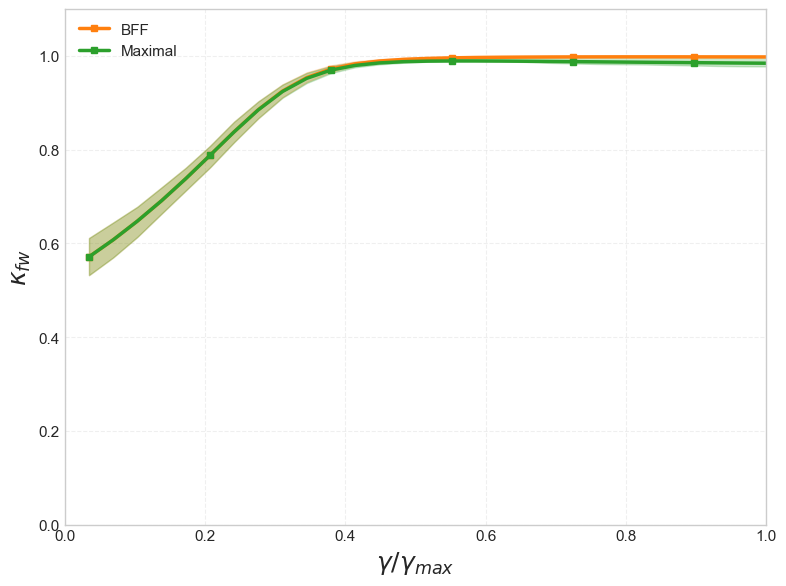

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

gamma_normalized = gamma_values / gamma_values.max()
mask = gamma_normalized > 0

for method_name in active_methods:
    if method_name == 'Original':
        continue
    
    cr_mean = results['networks'][method_name]['cr_mean'][mask]
    cr_p25 = results['networks'][method_name]['cr_p25'][mask]
    cr_p75 = results['networks'][method_name]['cr_p75'][mask]
    
    # Plot mean line
    line = ax.plot(gamma_normalized[mask], cr_mean, linewidth=2.5,
                   label=method_name, marker='s',color=colors[method_name.lower()],markersize=4, markevery=5)[0]
    
    # Fill 25-75 percentile band (network variability)
    ax.fill_between(gamma_normalized[mask], cr_p25, cr_p75,
                    alpha=0.25, color=colors[method_name.lower()])

ax.set_xlabel(r'$\gamma / \gamma_{max}$', fontsize=18, fontweight='bold')
ax.set_ylabel(r'$\kappa_{fw}$', fontsize=18, fontweight='bold')
# ax.set_title(f'Buffer Efficiency vs Shock Magnitude\n' +
#              f'Mean across {NUM_NETWORKS} networks (each averaged over {NUM_SHOCK_SCENARIOS} shocks)\n' +
#              f'Shaded: Network topology variability (25-75 percentile)',
#              fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(bottom=0, top=1.1)

plt.tight_layout()
plt.savefig('figures/Experiment2_figure2_kappa_vs_gamma.png', dpi=300, bbox_inches='tight')
plt.show()


## Individual Network Trajectories: κ_fw


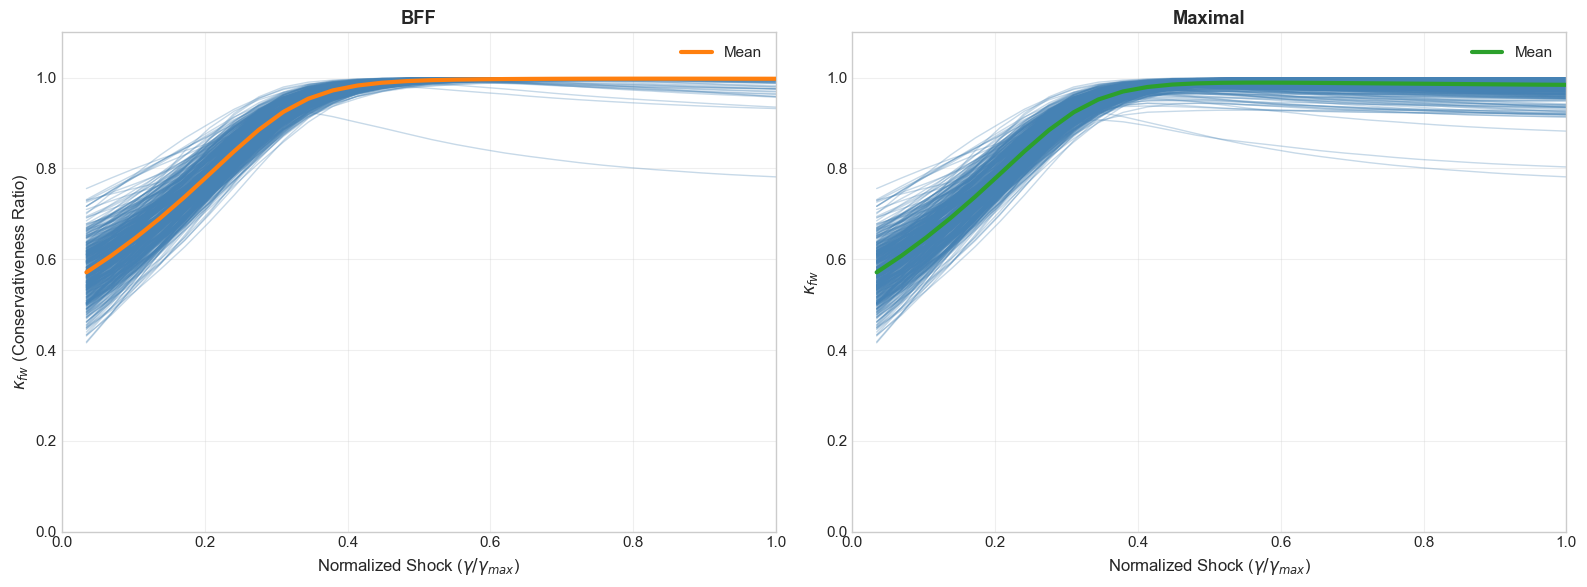

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

gamma_normalized = gamma_values / gamma_values.max()
mask = gamma_normalized > 0

# Plot 1: BFF
if 'BFF' in results['networks']:
    cr_networks = results['networks']['BFF']['cr_all_networks']
    cr_mean = results['networks']['BFF']['cr_mean']
    cr_p25 = results['networks']['BFF']['cr_p25']
    cr_p75 = results['networks']['BFF']['cr_p75']
    
    for net_idx in range(NUM_NETWORKS):
        ax1.plot(gamma_normalized[mask], cr_networks[net_idx, mask], 
                alpha=0.3, color='steelblue', linewidth=1)
    
    ax1.plot(gamma_normalized[mask], cr_mean[mask], 
            linewidth=3, color = '#ff7f0e', label='Mean', zorder=10)
    # ax1.fill_between(gamma_normalized[mask], cr_p25[mask], cr_p75[mask],
    #                  alpha=0.3, color='orange', label='25-75 percentile', zorder=5)
    
    ax1.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=12)
    ax1.set_ylabel(r'$\kappa_{fw}$ (Conservativeness Ratio)', fontsize=12)
    ax1.set_title(f'BFF', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1.1)

# Plot 2: Maximal
if 'Maximal' in results['networks']:
    cr_networks = results['networks']['Maximal']['cr_all_networks']
    cr_mean = results['networks']['Maximal']['cr_mean']
    cr_p25 = results['networks']['Maximal']['cr_p25']
    cr_p75 = results['networks']['Maximal']['cr_p75']
    
    for net_idx in range(NUM_NETWORKS):
        ax2.plot(gamma_normalized[mask], cr_networks[net_idx, mask],
                alpha=0.3, color='steelblue', linewidth=1)
    
    ax2.plot(gamma_normalized[mask], cr_mean[mask],
            linewidth=3, color='#2ca02c', label='Mean', zorder=10)
    # ax2.fill_between(gamma_normalized[mask], cr_p25[mask], cr_p75[mask],
    #                  alpha=0.3, color='#2ca02c', label='25-75 percentile', zorder=5)
    
    ax2.set_xlabel(r'Normalized Shock ($\gamma / \gamma_{max}$)', fontsize=12)
    ax2.set_ylabel(r'$\kappa_{fw}$', fontsize=12)
    ax2.set_title(f'Maximal', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()


## 9. Visualization 3: Alpha Star vs Gamma

Plot mean critical buffer multiplier with shaded standard deviation bands.

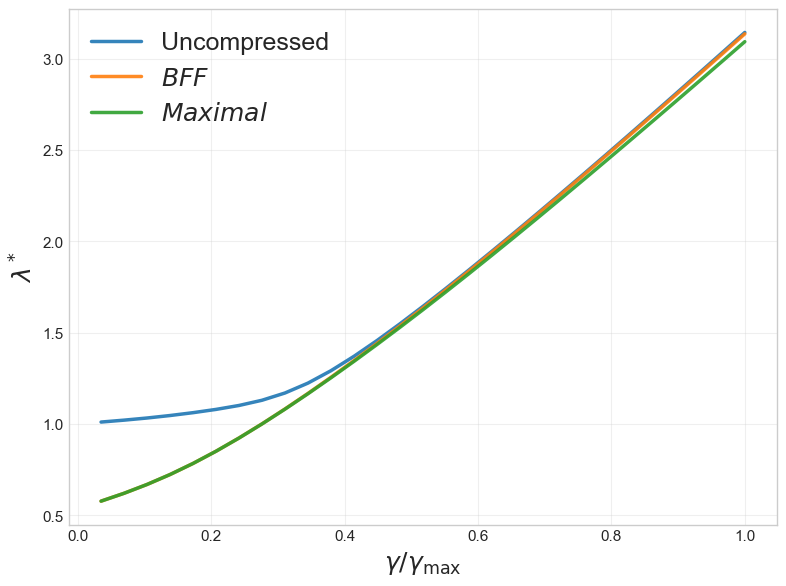

✓ Figure saved: experiment2_figure3_alpha_vs_gamma.png
  Shaded regions represent ± 1 standard deviation across 100 shock scenarios


In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for method_name in active_methods:
    alpha_mean = results['networks'][method_name]['alpha_mean'][mask]
    alpha_std = results['networks'][method_name]['alpha_std'][mask]
    
    # Plot mean line
    if method_name == 'Original':
        label = r'Uncompressed'
    else:
        label = rf'${method_name}$'
    
    ax.plot(gamma_normalized[mask], alpha_mean, '-', linewidth=2.5,
            label=label, color=colors[method_name.lower()], alpha=0.9)
    
    # # Shaded std region
    # ax.fill_between(gamma_values, alpha_mean - alpha_std, alpha_mean + alpha_std,
    #                  color=colors[method_name.lower()], alpha=0.2)

ax.set_xlabel(r'$\gamma / \gamma_{\mathrm{max}}$', fontsize=18)
ax.set_ylabel(r'$\lambda^*$', fontsize=18)
ax.legend(fontsize=18, framealpha=0.9, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('figures/experiment2_figure3_lambda_vs_gamma.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved: experiment2_figure3_alpha_vs_gamma.png")
print(f"  Shaded regions represent ± 1 standard deviation across {NUM_SHOCK_SCENARIOS} shock scenarios")